In [1]:
import pandas as pd
import numpy as np

import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from cataclop.ml import preprocessing
from cataclop.ml import exploration

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

load one of the saved programs in *ml/pipeline/programs*

In [2]:
program = factories.Program.factory('keras-test', version='1.0')

predict on validation dataset

In [3]:
program.predict(dataset_params = {
    'from': '2020-01-01',
    'to': '2020-07-10',
    'sub_categories': ['HANDICAP']
}, locked=True)

924 races


preparing model data


In [4]:
#from dill import dump, load
#weights = load(open('/tmp/weights.pkl', 'rb'))
#import keras
#program.model.model = keras.models.load_model('/tmp/model')
#program.model.model.load_weights('/tmp/weights.best.hdf5')

In [5]:
program.bet()

,race_id,start_at,category,sub_category,country,profit,num,position,final_odds_ref,final_odds,score,date
1,79972,2020-01-02 16:05:00,PLAT,HANDICAP,ARE,-6.0,2,4.0,0.153257,11.0,10.889018,2020-01-02 16:05:00
2,79972,2020-01-02 16:05:00,PLAT,HANDICAP,ARE,0.9,3,2.0,-0.398467,5.7,7.974101,2020-01-02 16:05:00
3,79972,2020-01-02 16:05:00,PLAT,HANDICAP,ARE,-6.0,4,10.0,0.038314,33.0,79000.483693,2020-01-02 16:05:00
4,79972,2020-01-02 16:05:00,PLAT,HANDICAP,ARE,-4.0,5,7.0,-0.363985,4.5,10.842047,2020-01-02 16:05:00
5,79972,2020-01-02 16:05:00,PLAT,HANDICAP,ARE,1.8,6,3.0,-0.191571,8.1,16.028419,2020-01-02 16:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...
6422,86782,2020-06-29 16:10:00,HAIE,HANDICAP,FRA,-6.0,11,11.0,0.689655,57.0,19999.742775,2020-06-29 16:10:00
6423,86782,2020-06-29 16:10:00,HAIE,HANDICAP,FRA,-6.0,12,7.0,0.651341,71.0,19913.059719,2020-06-29 16:10:00
6424,86782,2020-06-29 16:10:00,HAIE,HANDICAP,FRA,-6.0,13,20.0,1.264368,53.0,19805.679923,2020-06-29 16:10:00
6425,86782,2020-06-29 16:10:00,HAIE,HANDICAP,FRA,-6.0,14,20.0,0.766284,36.0,20239.850177,2020-06-29 16:10:00


In [6]:
program.bets.profit.describe()

count    1665.000000
mean       -0.556096
std        18.536386
min        -6.000000
25%        -6.000000
50%        -6.000000
75%        -2.000000
max       312.000000
Name: profit, dtype: float64

In [7]:
b = program.bets
b[b['final_odds']>10]['profit'].describe()

count    1053.000000
mean       -0.524881
std        22.455967
min        -6.000000
25%        -6.000000
50%        -6.000000
75%        -6.000000
max       312.000000
Name: profit, dtype: float64

In [8]:

def fast_bet(r):
    p = 'score'

    s = r.sort_values(by=p, ascending=False)
    o = s.index.sort_values(ascending=True, return_indexer=True)

    s2 = r.sort_values(by='final_odds_ref')
    o2 = s2.index.sort_values(ascending=True, return_indexer=True)

    s3 = r.sort_values(by='final_odds')
    o3 = s3.index.sort_values(ascending=True, return_indexer=True)

    r['pn'] = o[1]
    r['oddsrn'] = o2[1]
    r['oddsn'] = o3[1]
    r['pstd'] = r[p].std()

    return r


In [9]:
df = program.df
race_ids = df['race_id'].unique()
len(race_ids)

535

In [21]:
from cataclop.ml.exploration import random_race

#random_race(df, ['position', 'prize', 'sub_category', 'oddsn', 'num', 'final_odds', 'final_odds_ref', 'score', 'bet', 'profit', 'pn']).sort_values(by='score')

df[df['race_id']==86086][['position', 'prize', 'sub_category', 'oddsn', 'num', 'final_odds', 'final_odds_ref', 'score', 'bet', 'profit', 'pn']].sort_values(by='score')


,position,prize,sub_category,oddsn,num,final_odds,final_odds_ref,score,bet,profit,pn
5795,1.0,-3.411498,HANDICAP,2,1,5.0,-0.283525,0.000000,3,13.5,3
5796,4.0,-3.411498,HANDICAP,7,2,27.0,0.191571,0.000000,3,-6.0,4
5798,6.0,-3.411498,HANDICAP,3,4,8.2,-0.229885,0.000000,3,-6.0,5
5799,2.0,-3.411498,HANDICAP,0,5,2.5,-0.505747,0.000000,1,-0.7,6
5801,9.0,-3.411498,HANDICAP,5,7,17.0,0.229885,0.000000,3,-6.0,7
5803,8.0,-3.411498,HANDICAP,6,9,18.0,0.153257,0.000000,3,-6.0,8
5802,7.0,-3.411498,HANDICAP,8,8,39.0,-0.038314,40916.193211,3,-6.0,2
5800,3.0,-3.411498,HANDICAP,1,6,4.6,-0.505747,41504.604750,2,-1.2,1
5797,5.0,-3.411498,HANDICAP,4,3,17.0,0.268199,42097.038879,3,-6.0,0


In [12]:
df = df.groupby('race_id').apply(fast_bet)

In [27]:
df['bet'] = np.clip(df['oddsn'] + 1, 1, 3)
df['profit'] = df['bet'] * (df['winner_dividend'].fillna(0.)/100.-1.0) +  df['bet'] * (df['placed_dividend'].fillna(0.)/100.-1.0)# + (df_test['winner_dividend'].fillna(0.)/100.-1.0)

#df[ (df['pn']==0) & (df['prize'] > -0.3) & (df['score']>0.)]['profit'].describe()
df[(df['pn']==3) & (df['score'] > 0) & (df['final_odds'] > 10) ]['profit'].describe()

count    238.000000
mean      -0.930252
std       24.087590
min       -6.000000
25%       -6.000000
50%       -6.000000
75%       -6.000000
max      278.400000
Name: profit, dtype: float64

PLAT
137
                start_at        horse_name  race_id     prize sub_category  \
3    2020-01-02 16:05:00          AMBIANCE    79972  2.344389     HANDICAP   
20   2020-01-02 16:40:00  FESTIVAL OF AGES    79973  2.682640     HANDICAP   
32   2020-01-02 17:15:00           SUEDOIS    79974  2.682640     HANDICAP   
392  2020-01-09 19:35:00      BAY OF POETS    80240  2.344389     HANDICAP   
616  2020-01-16 15:30:00         BLUEBERRY    80493  2.344389     HANDICAP   
643  2020-01-16 16:40:00       DESERT FIRE    80495  2.682640     HANDICAP   
662  2020-01-16 17:50:00            LAIETH    80497  2.344389     HANDICAP   
865  2020-01-23 15:30:00    MASSIF CENTRAL    80761  2.344389     HANDICAP   
895  2020-01-23 18:25:00  FESTIVAL OF AGES    80766  2.344389     HANDICAP   
1019 2020-01-30 19:00:00  PIECE OF HISTORY    81022  2.344389     HANDICAP   

      final_odds  placed_dividend  position  bet  profit  stash  
3           33.0              0.0      10.0    3    -6.0   -6.0  


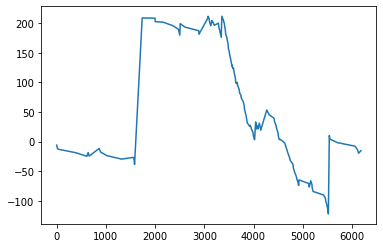

HAIE
10
                start_at      horse_name  race_id     prize sub_category  \
207  2020-01-05 14:57:00        BANONITO    80076  0.903426     HANDICAP   
314  2020-01-06 13:25:00         KAPSTAR    80108  0.595322     HANDICAP   
580  2020-01-14 17:20:00  FANTASTIC ROCK    80400  1.312243     HANDICAP   
1170 2020-02-02 17:57:00  FEU D'ARTIFICE    81136  0.595322     HANDICAP   
1458 2020-02-10 15:57:00  ELIGLOTE VILLE    81437  0.595322     HANDICAP   
2095 2020-03-01 16:29:00      CASTANELLA    82597  1.541498     HANDICAP   
2302 2020-03-07 15:17:00    PURPLE LIGHT    82813  2.097714     HANDICAP   
6249 2020-06-21 14:17:00     SAINT ANJOU    86533  0.832956     HANDICAP   
6328 2020-06-23 13:50:00  FUN DES MOTTES    82506  1.261123     HANDICAP   
6425 2020-06-29 16:10:00      IN EXTENSO    86782  0.638059     HANDICAP   

      final_odds  placed_dividend  position  bet  profit  stash  
207          4.0              0.0       4.0    1    -2.0   -2.0  
314         67.0       

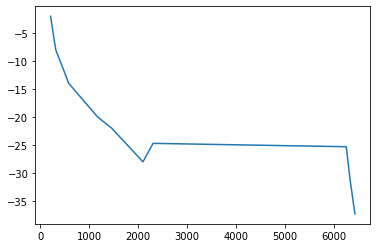

STEEPLECHASE
5
                start_at          horse_name  race_id     prize sub_category  \
322  2020-01-06 15:56:00         DESAGUADERO    80112  0.903426     HANDICAP   
2449 2020-03-11 12:30:00      GALLOPING STAR    82987  1.408835     HANDICAP   
5591 2020-05-17 15:23:00           CAFERTITI    85518  2.735795     HANDICAP   
6248 2020-06-21 13:44:00  ROYAL NAVY WARSHIP    86532  1.207916     HANDICAP   
6310 2020-06-23 13:12:00            TAKE TWO    82505  1.806869     HANDICAP   

      final_odds  placed_dividend  position  bet  profit  stash  
322          6.7              0.0      20.0    3    -6.0   -6.0  
2449        10.0              0.0      20.0    3    -6.0  -12.0  
5591        23.0            510.0       2.0    3     9.3   -2.7  
6248        23.0              0.0       5.0    3    -6.0   -8.7  
6310        40.0              0.0       4.0    3    -6.0  -14.7  


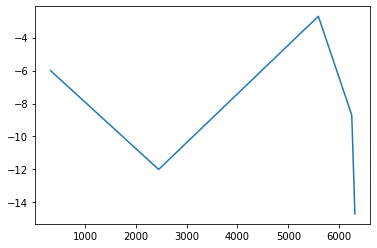

In [15]:
from matplotlib import pyplot as plt
for cat in df['category'].value_counts().index:
    print(cat)
    g = df[ (df['pn']==0) & (df['prize'] > 0.3) & (df['category']==cat) & (df['score']>0.)].copy()
    g['stash'] = g['profit'].cumsum()
    print(len(g))
    pd.set_option('display.max_rows', 1000)
    print(g[['start_at', 'horse_name', 'race_id', 'prize', 'sub_category', 'final_odds', 'placed_dividend', 'position', 'bet', 'profit', 'stash']].head(10))
    g['stash'].plot()
    plt.show()